In [1]:
import torch

from train_sae.models.transformer import trunk_and_head_from_pretrained
from train_sae.saes.crosscoder import CrossCoderSAE

In [2]:
import functools

import matplotlib.pyplot as plt

In [3]:
device = "cuda:7"
addition_cc = CrossCoderSAE(2, 128, 2048, "vanilla", {"sparsity": 0.01}).to(device)
addition_cc.load_state_dict(
    torch.load("./model_25000_flops_1.61e+14.pt", map_location=device)
)

pre_feat, pre_decoder = trunk_and_head_from_pretrained(
    "./1100-train=1.00-test=0.53.pt",
    1,
    device,
    torch.float32,
    99,
    128,
    512,
    4,
    2,
    use_geglu=False,
    max_seq_len=2048,
    use_learned_pos_emb=True,
    norm_layer="LayerNorm",
)
post_feat, post_decoder = trunk_and_head_from_pretrained(
    "./1700-train=1.00-test=1.00.pt",
    1,
    device,
    torch.float32,
    99,
    128,
    512,
    4,
    2,
    use_geglu=False,
    max_seq_len=2048,
    use_learned_pos_emb=True,
    norm_layer="LayerNorm",
)

/tmp/ipykernel_2347464/3955769390.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("./model_25000_flops_1.61e+14.pt", map_location=device)
/home/cadegord/proje

In [4]:
addition_dec1_weights = addition_cc.autoencoders[0].decoder.weight.detach()
addition_dec2_weights = addition_cc.autoencoders[1].decoder.weight.detach()
addition_dec1_weight_norms = addition_dec1_weights.norm(dim=0)
addition_dec2_weight_norms = addition_dec2_weights.norm(dim=0)

addition_relative_norms = addition_dec1_weight_norms / (
    addition_dec1_weight_norms + addition_dec2_weight_norms
)
addition_relative_norms = addition_relative_norms.numpy(force=True)

In [5]:
# create train and test addition data
from itertools import product

from torch.utils.data import DataLoader

prime = 97

data = []
for a, b in product(range(prime), range(prime)):
    data.append([a, 97, b, 98, (a + b) % prime])

data = torch.tensor(data)

generator = torch.Generator().manual_seed(42)
train_data, test_data = torch.utils.data.random_split(
    data, [0.5, 0.5], generator=generator
)

train_dataloader = DataLoader(
    train_data,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
)
test_dataloader = DataLoader(
    test_data,
    batch_size=512,
    shuffle=False,
    pin_memory=True,
)

In [6]:
all_data = []
pre_generalization_data = []
post_generalization_data = []
all_encoded = []
pre_generalization_is_correct = []
post_generalization_is_correct = []

# get train and test accuracy with a cross coder
pre_train_correct = 0
pre_train_total = 0
post_train_correct = 0
post_train_total = 0
for batch in train_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    all_data.append(batch)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        zs = [pre_feat(x), post_feat(x)]
        z_normalizing_factors = [
            pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
        ]
        zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
        pre_generalization_data.append(addition_cc.autoencoders[0].encoder(zs[0]))
        post_generalization_data.append(addition_cc.autoencoders[1].encoder(zs[1]))
        encoded_pre_activation = (
            pre_generalization_data[-1] + post_generalization_data[-1]
        )
        encoded = addition_cc.activation_fn(encoded_pre_activation)
        all_encoded.append(encoded)
        # encoded = addition_cc.encode(zs)
        z_hats = [
            autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
        ]
        z_hats = [z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)]
        pre_preds = pre_decoder(z_hats[0])[:, -1, :]
        post_preds = post_decoder(z_hats[1])[:, -1, :]
        pre_generalization_is_correct.append(pre_preds.argmax(dim=1) == y)
        post_generalization_is_correct.append(post_preds.argmax(dim=1) == y)
        pre_train_correct += pre_generalization_is_correct[-1].sum().item()
        pre_train_total += y.size(0)
        post_train_correct += post_generalization_is_correct[-1].sum().item()
        post_train_total += y.size(0)
print(f"Pre train accuracy: {pre_train_correct / pre_train_total}")
print(f"Post train accuracy: {post_train_correct / post_train_total}")

pre_test_correct = 0
pre_test_total = 0
post_test_correct = 0
post_test_total = 0
for batch in test_dataloader:
    batch = batch.long()
    batch = batch.to(device)
    all_data.append(batch)
    x, y = batch[:, :4], batch[:, 4]
    with torch.no_grad():
        zs = [pre_feat(x), post_feat(x)]
        z_normalizing_factors = [
            pre_feat.embed_dim**0.5 / z.norm(dim=-1, keepdim=True) for z in zs
        ]
        zs = [z * z_normalizing_factors[i] for i, z in enumerate(zs)]
        pre_generalization_data.append(addition_cc.autoencoders[0].encoder(zs[0]))
        post_generalization_data.append(addition_cc.autoencoders[1].encoder(zs[1]))
        encoded_pre_activation = (
            pre_generalization_data[-1] + post_generalization_data[-1]
        )
        encoded = addition_cc.activation_fn(encoded_pre_activation)
        all_encoded.append(encoded)
        # encoded = addition_cc.encode(zs)
        z_hats = [
            autoencoder.decoder(encoded) for autoencoder in addition_cc.autoencoders
        ]
        z_hats = [z_hat / z_normalizing_factors[i] for i, z_hat in enumerate(z_hats)]
        pre_preds = pre_decoder(z_hats[0])[:, -1, :]
        post_preds = post_decoder(z_hats[1])[:, -1, :]
        pre_generalization_is_correct.append(pre_preds.argmax(dim=1) == y)
        post_generalization_is_correct.append(post_preds.argmax(dim=1) == y)
        pre_test_correct += pre_generalization_is_correct[-1].sum().item()
        pre_test_total += y.size(0)
        post_test_correct += post_generalization_is_correct[-1].sum().item()
        post_test_total += y.size(0)
print(f"Pre test accuracy: {pre_test_correct / pre_test_total}")
print(f"Post test accuracy: {post_test_correct / post_test_total}")

Pre train accuracy: 1.0
Post train accuracy: 1.0
Pre test accuracy: 0.5318877551020408
Post test accuracy: 0.9963860544217688


In [7]:
all_data = torch.cat(all_data)
all_encoded = torch.cat(all_encoded)
pre_generalization_data = torch.cat(pre_generalization_data)
post_generalization_data = torch.cat(post_generalization_data)
pre_generalization_is_correct = torch.cat(pre_generalization_is_correct)
post_generalization_is_correct = torch.cat(post_generalization_is_correct)

In [8]:
padding_zeros = torch.zeros(all_data.shape[0], 1, 2048).to(device)
all_encoded = torch.cat([all_encoded, padding_zeros], dim=1)
pre_generalization_data = torch.cat([pre_generalization_data, padding_zeros], dim=1)
post_generalization_data = torch.cat([post_generalization_data, padding_zeros], dim=1)

In [9]:
print(all_encoded.shape)
print(pre_generalization_data.shape)
print(post_generalization_data.shape)
print(all_data.shape)
print(pre_generalization_is_correct.shape)
print(post_generalization_is_correct.shape)

torch.Size([9409, 5, 2048])
torch.Size([9409, 5, 2048])
torch.Size([9409, 5, 2048])
torch.Size([9409, 5])
torch.Size([9409])
torch.Size([9409])


In [10]:
import ipywidgets
from IPython.display import display

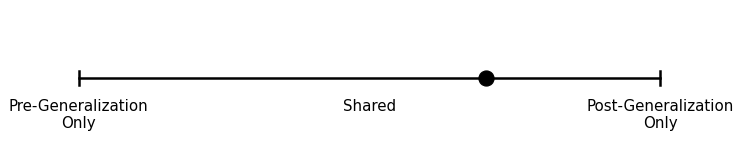

In [11]:
def create_slider_plot(value):
    # Ensure the value is between 0 and 1
    value = max(0, min(1, value))
    value = 1 - value  # done to match the dashoard

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 2), dpi=90)

    # Create the horizontal line
    ax.plot([0, 1], [0, 0], "k-", linewidth=2)

    # Add vertical ticks at the ends
    ax.plot([0, 0], [-0.05, 0.05], "k-", linewidth=2)  # Left tick
    ax.plot([1, 1], [-0.05, 0.05], "k-", linewidth=2)  # Right tick

    # Place the dot at the value position
    ax.plot(value, 0, "o", markersize=12, color="black")

    # Add the labels
    ax.text(0, -0.15, "Pre-Generalization\nOnly", ha="center", va="top", fontsize=12)
    ax.text(0.5, -0.15, "Shared", ha="center", va="top", fontsize=12)
    ax.text(1, -0.15, "Post-Generalization\nOnly", ha="center", va="top", fontsize=12)

    # Remove axis ticks and labels
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.5, 0.5)
    ax.axis("off")

    return fig


# Example usage with a value of 0.3
value = 0.3
fig = create_slider_plot(value)
plt.show()

In [12]:
# ideas:
# histogram of the crosscoder activations
# show the predicted value instead of the target
# add various hovering capabilities?

In [13]:
TOPK = 20
# Create dropdown for selecting data element
dropdown = ipywidgets.Dropdown(
    options=[(f"Element {i}", i) for i in range(all_encoded.shape[2])],
    value=0,
    description="Select:",
)

# Create forward and back buttons
back_button = ipywidgets.Button(description="←", layout=ipywidgets.Layout(width="40px"))
forward_button = ipywidgets.Button(
    description="→", layout=ipywidgets.Layout(width="40px")
)


def token_to_text(token):
    if token == 97:
        return "+"
    elif token == 98:
        return "="
    else:
        return token


def on_back_button_clicked(b):
    if dropdown.value > 0:
        dropdown.value -= 1


def on_forward_button_clicked(b):
    if dropdown.value < len(all_data) - 1:
        dropdown.value += 1


# Pre-compute all HTML for faster rendering
@functools.lru_cache(maxsize=32)  # Cache the results to avoid recomputation
def generate_html_for_element(element_idx):
    """Generate all the HTML needed for a specific element index"""
    html_parts = []

    # Add column headers HTML
    headers_html = (
        '<div style="display: flex; align-items: center; margin-bottom: 10px;">'
    )
    headers_html += '<span style="width: 50px;"></span>'
    headers_html += (
        '<span style="font-weight: bold; margin-right: 55px;">Pre-generalization</span>'
    )
    headers_html += '<span style="margin: 0 10px;">|</span>'
    headers_html += (
        '<span style="font-weight: bold; margin-right: 55px;">'
        "Crosscoder Features"
        "</span>"
    )
    headers_html += '<span style="margin: 0 10px;">|</span>'
    headers_html += '<span style="font-weight: bold;">Post-generalization</span>'
    headers_html += "</div>"

    idx = torch.argsort(
        torch.max(all_encoded[:, :, element_idx], dim=1)[0], descending=True
    )[:TOPK]
    data_reordered = all_data[idx]

    selected_data_l = pre_generalization_data[idx, :, element_idx]
    selected_data_l_min = torch.min(selected_data_l)
    selected_data_l_max = torch.max(selected_data_l)
    selected_data_l_correct = pre_generalization_is_correct[idx]

    selected_data_c = all_encoded[idx, :, element_idx]
    selected_data_c_max = torch.max(selected_data_c)

    selected_data_r = post_generalization_data[idx, :, element_idx]
    selected_data_r_min = torch.min(selected_data_r)
    selected_data_r_max = torch.max(selected_data_r)
    selected_data_r_correct = post_generalization_is_correct[idx]
    selected_data_lr_max = max(
        selected_data_l_max,
        selected_data_r_max,
        abs(selected_data_l_min),
        abs(selected_data_r_min),
    )

    # Base style string
    base_style = (
        "padding: 5px; border-radius: 5px; margin: 2px; display: inline-block;"
        " width: 20px; height: 28px; text-align: center; overflow: hidden;"
    )

    # Create rows HTML
    for idx, (
        text_data,
        row_data_l,
        row_data_c,
        row_data_r,
        row_data_l_correct,
        row_data_r_correct,
    ) in enumerate(
        zip(
            data_reordered,
            selected_data_l,
            selected_data_c,
            selected_data_r,
            selected_data_l_correct,
            selected_data_r_correct,
        ),
        1,
    ):
        row_html = '<div style="display: flex; align-items: center; margin: 5px 0;">'

        # Add row number
        row_html += (
            '<span style="margin-right: 10px; font-weight: bold;'
            f' width: 30px; text-align: center;">{idx}.</span>'
        )

        # Left side (blue background and orange background)
        for i, (text, value) in enumerate(zip(text_data, row_data_l)):
            if value > 0:
                opacity = float(value / selected_data_lr_max)
                style = f"{base_style} background: rgba(173, 216, 230, {opacity});"
            else:
                opacity = (
                    float(abs(value) / selected_data_lr_max)
                    if selected_data_lr_max != 0
                    else 0
                )
                style = f"{base_style} background: rgba(255, 218, 185, {opacity});"

            # color last token green if correct, red if incorrect
            if i == 4:
                if row_data_l_correct:
                    style += "border: 2px solid green;"
                else:
                    style += "border: 2px dashed red;"
            row_html += f'<span style="{style}">{token_to_text(text)}</span>'

        # Add separator
        row_html += '<span style="margin: 0 10px;">|</span>'

        # Center side (green background)
        for text, value in zip(text_data, row_data_c):
            opacity = (
                float(value / selected_data_c_max) if selected_data_c_max != 0 else 0
            )
            style = f"{base_style} background: rgba(128, 222, 105, {opacity});"
            row_html += f'<span style="{style}">{token_to_text(text)}</span>'

        # Add separator
        row_html += '<span style="margin: 0 10px;">|</span>'

        # Right side (light orange background)
        for i, (text, value) in enumerate(zip(text_data, row_data_r)):
            if value > 0:
                opacity = float(value / selected_data_lr_max)
                style = f"{base_style} background: rgba(173, 216, 230, {opacity});"
            else:
                opacity = float(abs(value) / selected_data_lr_max)
                style = f"{base_style} background: rgba(255, 218, 185, {opacity});"

            # color last token green if correct, red if incorrect
            if i == 4:
                if row_data_r_correct:
                    style += "border: 2px solid green;"
                else:
                    style += "border: 2px dashed red;"
            row_html += f'<span style="{style}">{token_to_text(text)}</span>'

        row_html += "</div>"
        html_parts.append(row_html)

    return headers_html, html_parts


# Create an output widget for the plot that will be reused
plot_output = ipywidgets.Output()

# Create a single HTML widget for all the rows
rows_html = ipywidgets.HTML()


def update_display(change):
    element_idx = change["new"]

    # Update the plot
    with plot_output:
        plot_output.clear_output(wait=True)
        plt.figure(figsize=(8, 2))  # Smaller figure for faster rendering
        fig = create_slider_plot(addition_relative_norms[element_idx])
        plt.show(fig)

    # Update the HTML content
    headers_html, rows_html_parts = generate_html_for_element(element_idx)
    full_html = headers_html + "".join(rows_html_parts)
    rows_html.value = full_html


# Connect dropdown to update function
dropdown.observe(update_display, names="value")

# Connect button click handlers
back_button.on_click(on_back_button_clicked)
forward_button.on_click(on_forward_button_clicked)

# Initial display
update_display({"new": 0})

# Create horizontal box for controls
controls = ipywidgets.HBox([back_button, dropdown, forward_button])

# Stack controls and display box vertically
display_box = ipywidgets.VBox([plot_output, rows_html])
vbox = ipywidgets.VBox([controls, display_box])
display(vbox)